In [4]:
import numpy as np
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation, binary_erosion

In [32]:
# Set paths
MODEL_PATH = "models/my_segmentation_model_100_efficientnet.h5"
IMAGE_PATH = "new.jpeg"  # Change this to your MRI image file

# Load model
try:
    model = tf.keras.models.load_model(MODEL_PATH, compile=False)
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    model = None

✅ Model loaded successfully!


In [33]:
import cv2
import numpy as np

# Function to preprocess image
def preprocess_image(image_path, target_size=(128, 128)):
    # Load image in grayscale mode
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Error handling if the image is not loaded
    if image is None:
        raise ValueError(f"Error loading image: {image_path}. Check if the file exists and is a valid image.")

    # Resize image to target size
    image = cv2.resize(image, target_size)
    
    # Expand dimensions to (height, width, 1)
    image = np.expand_dims(image, axis=-1)
    
    # Convert grayscale to 3-channel (BGR-like) by repeating across channels
    image = np.repeat(image, 3, axis=-1)
    
    # Normalize pixel values to [0,1] range
    image = image / 255.0

    # Expand dimensions for model input (batch_size, height, width, channels)
    return np.expand_dims(image, axis=0), image.squeeze()


In [34]:
# Load and preprocess image
image, original_image = preprocess_image(IMAGE_PATH)
print("Image loaded and preprocessed.")
print("Preprocessed Shape:", image.shape)  # Should be (1, 128, 128, 3)

# Predict mask
prediction = model.predict(image)[0]
print("Prediction completed.")


Image loaded and preprocessed.
Preprocessed Shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction completed.


Min: 0.5000392198562622, Max: 0.7299895882606506


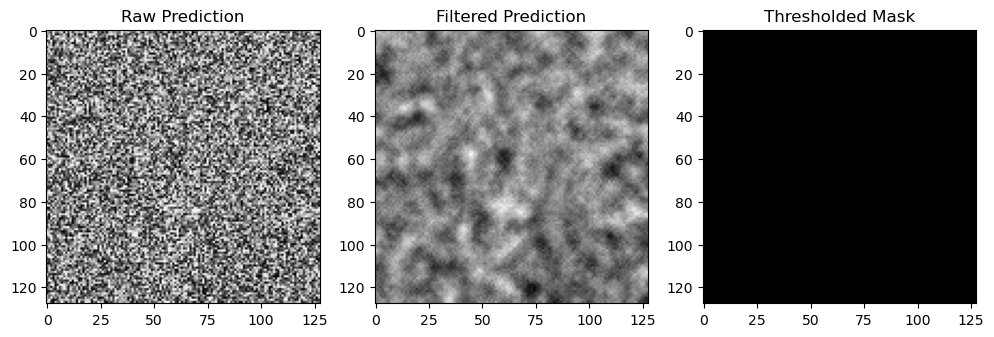

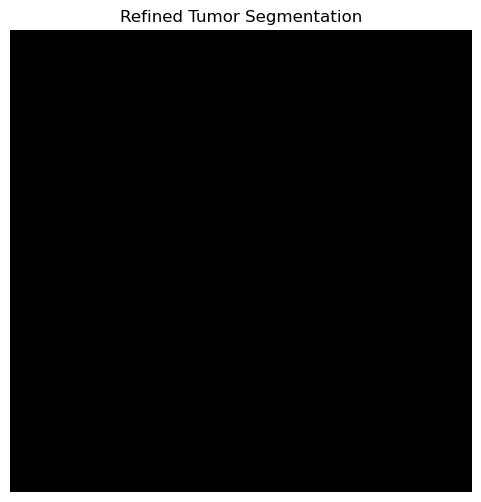

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Simulated Model Prediction (Replace with real output)
prediction = np.random.rand(128, 128).astype(np.float32) * 0.23 + 0.5  # Example range [0.5, 0.73]

# Debugging: Check Prediction Range
print(f"Min: {prediction.min()}, Max: {prediction.max()}")

# Apply Bilateral Filtering
filtered_prediction = cv2.bilateralFilter(prediction.astype(np.float32), d=9, sigmaColor=75, sigmaSpace=75)

# Adjust Threshold (Lower if full black output)
threshold = 0.5  # Start with 0.5, lower to 0.45 if needed
binary_mask = np.where(filtered_prediction > threshold, 1, 0).astype(np.uint8)

# Debugging: Show Intermediate Outputs
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(prediction, cmap="gray")
plt.title("Raw Prediction")

plt.subplot(1, 3, 2)
plt.imshow(filtered_prediction, cmap="gray")
plt.title("Filtered Prediction")

plt.subplot(1, 3, 3)
plt.imshow(binary_mask, cmap="gray")
plt.title("Thresholded Mask")

plt.show()

# Remove Small Noise Regions
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
min_area = 100  # Adjust if needed
filtered_mask = np.zeros_like(binary_mask)

for i in range(1, num_labels):  
    if stats[i, cv2.CC_STAT_AREA] > min_area:
        filtered_mask[labels == i] = 1  

# Apply Morphological Closing
kernel = np.ones((7,7), np.uint8)
filtered_mask = cv2.morphologyEx(filtered_mask, cv2.MORPH_CLOSE, kernel)

# Show Final Output
plt.figure(figsize=(6,6))
plt.imshow(filtered_mask, cmap="gray")
plt.title("Refined Tumor Segmentation")
plt.axis("off")
plt.show()


In [17]:
import cv2
import numpy as np

# Function to generate heatmap
def generate_heatmap(original_image, mask, colormap=cv2.COLORMAP_JET):
    # Remove batch dimension if present
    if len(original_image.shape) == 4:  # (1, 128, 128, 3)
        original_image = original_image[0]  # Convert to (128, 128, 3)

    # Convert original image from float32 [0,1] to uint8 [0,255]
    if original_image.dtype == np.float32 or original_image.dtype == np.float64:
        original_image = (original_image * 255).astype(np.uint8)

    # Ensure mask has correct shape
    if len(mask.shape) == 4:  # (1, 128, 128, 1) -> (128, 128)
        mask = mask[0, :, :, 0]
    elif len(mask.shape) == 3:  # (128, 128, 1) -> (128, 128)
        mask = mask[:, :, 0]

    mask_resized = cv2.resize((mask * 255).astype(np.uint8), (original_image.shape[1], original_image.shape[0]))
    heatmap = cv2.applyColorMap(mask_resized, colormap)

    # Ensure original image is BGR
    if original_image.shape[-1] == 1:  # Grayscale (128,128,1)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)

    # Apply heatmap overlay
    overlay = cv2.addWeighted(original_image, 0.6, heatmap, 0.4, 0)
    return overlay

# Example usage
original_image = np.random.rand(1, 128, 128, 3).astype(np.float32)  # Simulated batch image (1, 128, 128, 3)
mask = np.random.rand(1, 128, 128, 1) > 0.7  # Simulated binary mask (1, 128, 128, 1)

heatmap = generate_heatmap(original_image, mask)
cv2.imwrite("heatmap_output.png", heatmap)

print("✅ Heatmap generated successfully!")


✅ Heatmap generated successfully!


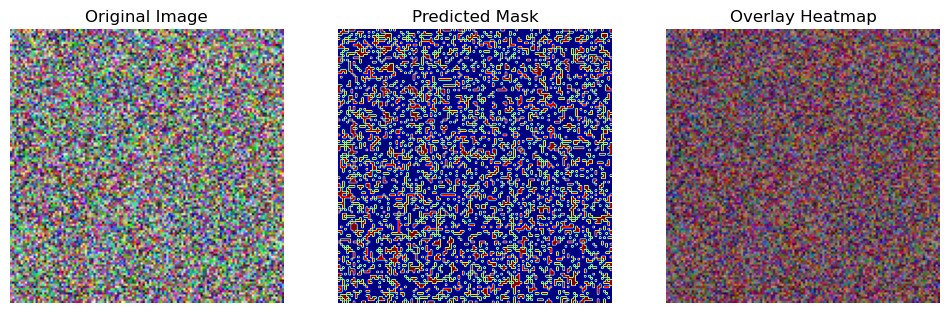

✅ Visualization completed!


In [19]:
import matplotlib.pyplot as plt

# Remove batch dimension for visualization
original_image_vis = original_image.squeeze()  # Shape: (128, 128, 3)
mask_vis = mask.squeeze()  # Shape: (128, 128)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(original_image_vis, cmap='gray')  # Ensure correct shape
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask_vis, cmap='jet')  # Ensure mask is 2D
plt.title("Predicted Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(heatmap)  # No need to squeeze heatmap, already correct
plt.title("Overlay Heatmap")
plt.axis("off")

plt.show()
print("✅ Visualization completed!")
